In [56]:
# Code referenced from:
# https://www.kaggle.com/code/albeffe/text-clustering-tfidf-pca-beginner-tutorial

import csv
import os
import re
import string
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from langdetect import detect
import matplotlib.pyplot as plt
import math
import statistics as stats
from wordcloud import WordCloud
from mlxtend.frequent_patterns import fpgrowth
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from snorkel.labeling import labeling_function

## run once
# import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Load Data

In [57]:
DISPLAY_ALL_TEXT = False

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)
pd.set_option('display.max_rows', 50)

In [128]:
df = pd.read_csv('../airflow/data/staging/result_big_table/result.csv',
                 sep='\\t',
                 header=None,
                 engine='python',
                 names=['job_id', 'job_title', 'company_name', 
                        'job_description', 'location', 'official_post_date',
                        'min_official_salary', 'max_official_salary', 'career_level',
                        'qualification', 'job_type', 'job_functions', 'industry',
                        'min_salary', 'max_salary']
                )
df.drop_duplicates(subset=['job_description', 'job_title', 'company_name'], keep='last', inplace=True)

# formatting
df['job_description'] = df['job_description'].astype(str)
df = df.replace(r'\\n+|\\t+\\r+',' ', regex=True)
df['mid_salary'] = ((df['min_salary'] + df['max_salary']) / 2).astype(int)

#### Label Agency Jobs

In [129]:
agency_df = pd.read_csv('agency_list.csv')

agency_names = agency_df[agency_df.is_agency == True].company_name
non_agency_names = agency_df[agency_df.is_agency == False].company_name

def label_agency(job_description, company_name):
    if company_name in non_agency_names:
        return False
    elif company_name in agency_names:
        return True
    elif re.search(r"\bmy client[^'s]", job_description, flags=re.I):
        return True
    elif re.search(r"\bour client[^'s]", job_description, flags=re.I):
        return True
    else:
        return False
    
df['agency'] = df.apply(lambda x: label_agency(x['job_description'], x['company_name']), axis=1)

#### Filter to data-related jobs only

In [135]:
df = df[df.job_title.str.contains('Data|Machine Learning|Business Intelligence|Analytics|Computer Vision|Deep Learning', 
                                               flags=re.IGNORECASE, regex=True)|
        df.job_title.str.contains('(AI|BI|ML|MLE|ETL|SQL|NLP)[\n)\s\]]', 
                                            regex=True)]

In [136]:
df.sample(20)

,job_id,job_title,company_name,job_description,location,official_post_date,min_official_salary,max_official_salary,career_level,qualification,job_type,job_functions,industry,min_salary,max_salary,mid_salary,agency
31617,100003009572723,SOC/ Data Centre Operator | Fresh Graduates ar...,Morgan McKinley,KEY ACCOUNTABILITIES * Perform daily monitorin...,NaN,2022-08-04,NaN,NaN,Entry Level,Degree,"Full Time, Permanent",Information Technology (IT); Support; Network ...,Human Resources Management/Consultancy,11000,30000,20500,False
5280,100003009774504,System Analyst (Database Administrator),Hong Kong Baptist Hospital,Key Duties and Responsibilities: Perform datab...,Kowloon Bay,2022-10-13,NaN,NaN,Middle,Degree,"Full Time, Contract",Information Technology (IT); DBA; Support; Others,Health & Beauty Care,30000,60000,45000,False
43762,100003009622028,"Senior Manager /Manager, Distribution Planning...",AXA Hong Kong,Job Responsibilities: Assist supervisor to dri...,Southern Area,2022-08-20,NaN,NaN,Senior,Degree,Full Time,"Insurance;Others;Sales, CS & Business Devpt;Ch...",Insurance/Pension Funding,30000,80000,55000,False
45455,100003009557046,Contract Data Analyst,Bank of Communications Trustee Limited,Responsibilities Perform digital data analysis...,NaN,2022-07-29,NaN,NaN,Entry Level,Degree,"Full Time, Contract",Professional Services; Business Analysis / Dat...,Financial Services,11000,30000,20500,False
14970,100003009540924,Electrical / MVAC Engineer -Data Centre,Spencer Ogden (Hong Kong) Limited,Our client is a leading provider of telecommun...,Others,2022-07-23,NaN,NaN,NaN,NaN,"Full Time, Permanent",Engineering; Electrical / Electronics; Enginee...,Human Resources Management/Consultancy,20000,50000,35000,True
1551,100003009777033,Business Data Analyst / Manager,Midland Holdings Limited,Job Highlights Bring the company to the next l...,Central,2022-10-14,NaN,NaN,Middle,Degree,"Full Time, Permanent",Marketing / Public Relations; Marketing - Mark...,Property Management / Consultancy,20000,50000,35000,False
34743,100003009545437,Contract Support (Data Centre Solutions),CBRE Pte Ltd,PURPOSE OF THE JOB Provide a comprehensive fin...,NaN,2022-07-25,NaN,NaN,Middle,Degree,"Full Time, Permanent",Admin & HR; Clerical / Admin Staff; Others; Pr...,Property Management / Consultancy,15000,20000,17500,False
10600,100003009667919,Data Engineer - Premium Brand,Profile Search and Selection,Our client is a global premium brand in Hong K...,NaN,2022-09-07,NaN,NaN,Middle,Degree,Full Time,Information Technology (IT);Product Management...,Human Resources Management/Consultancy,40000,80000,60000,True
15187,100003009544372,"Vice President / Assistant Vice President, Dat...",CMB Wing Lung Bank Limited,Responsibilities: Develop and drive data gover...,Mong Kok,2022-07-25,NaN,NaN,NaN,NaN,"Full Time, Permanent",Banking / Finance; Analyst,Financial Services,40000,80000,60000,False
29882,100003009740874,Machine Learning Engineer,Orient Overseas Container Line Ltd (OOCL),We are looking for a Machine Learning Engineer...,Shatin Area,2022-09-30,NaN,NaN,NaN,NaN,"Full Time, Permanent",Information Technology (IT); Software Developm...,Freight Forwarding/Delivery/Shipping,20000,40000,30000,False


# Prepare for Kmeans clustering
Use TFIDF to convert words to features and use Kmeans to separate into clusters

#### Pre-processing for text feature - tokenization and stop words

In [61]:
class LemmaTokenizer(object):

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, document):
        lemmas = []
        
        # Pre-proccessing of one document at the time
        
        # Removing puntuation
        translator_1 = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
        document = document.translate(translator_1)

        # Removing numbers
        document = re.sub(r'\d+', ' ', document)

        # Removing special characters
        document = re.sub(r"[^a-zA-Z0-9]+", ' ', document)

        # The document is a string up to now, after word_tokenize(document) we'll work on every word one at the time
        for token in word_tokenize(document):
            
            # Removing spaces
            token = token.strip()
            
            # Lemmatizing
            token = self.lemmatizer.lemmatize(token)

            # Removing stopwords
            if token not in stopwords and len(token) > 2:
                lemmas.append(token)
        return lemmas


def custom_import_stopwords(filename):
    in_stopword_list = []
    in_flag = 0
    in_word_cnt = 0

    with open(filename, encoding="utf8") as f:
        for row in csv.reader(f):
            if in_flag == 0:
                in_flag = 1
            else:
                in_stopword_list.append(row[0])
                in_word_cnt += 1

    print(f"{in_word_cnt} stopwords imported")
    return in_stopword_list

#### Use TFIDF to convert words to features

We use both the job title and job description.

In [62]:
stopwords = custom_import_stopwords('english_stopwords.csv')

# Custom tokenizer for tfidf representation
vectorizer = TfidfVectorizer(input='content', tokenizer=LemmaTokenizer(), ngram_range=(1, 2))

# Here we need the correct path in order to give it to the vectorizer
print("Generating TFIDF sparse matrix...")
X = (df['job_description'] + ' ' + df['job_title']).values
X_tfidf = vectorizer.fit_transform(X)

# Trials, uncomment the line to start clustering but mind the parameter for the number of clusters
word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
# for i in range(5, 20):
#     generate_wordclouds(X_svd, X_tfidf, i, word_positions, only_clustering=True)

789 stopwords imported
Generating TFIDF sparse matrix...


#### Use PCA to reduce dimension

In [65]:
# Dimensionality reduction
svd = TruncatedSVD(n_components=128, random_state=42, n_iter=5)
X_svd = svd.fit_transform(X_tfidf)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.13


#### Run K means and visualize with word clouds

For n_clusters = 10 The average silhouette_score is : 0.08543007922727076


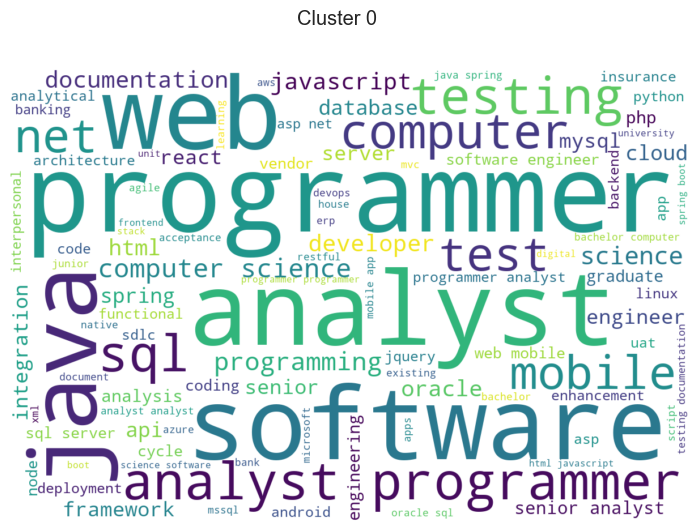

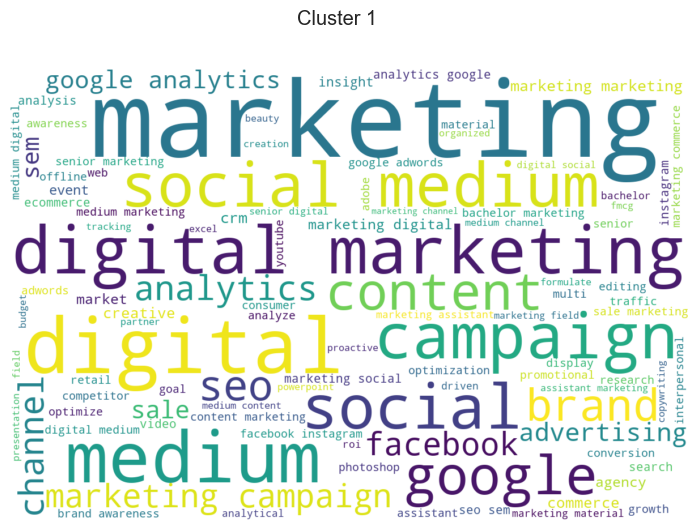

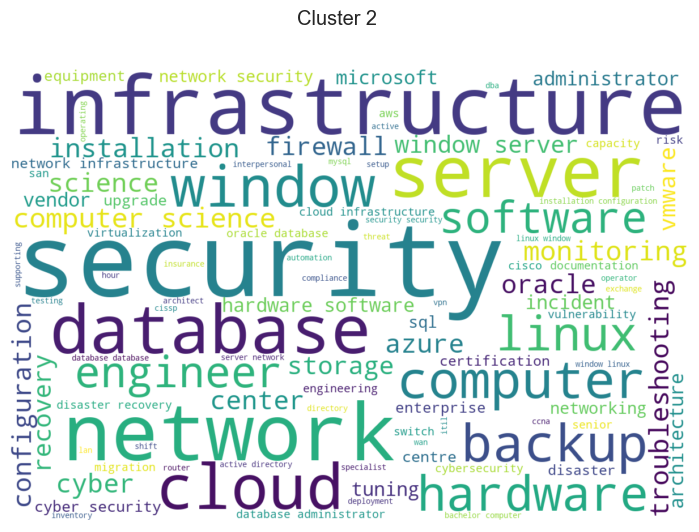

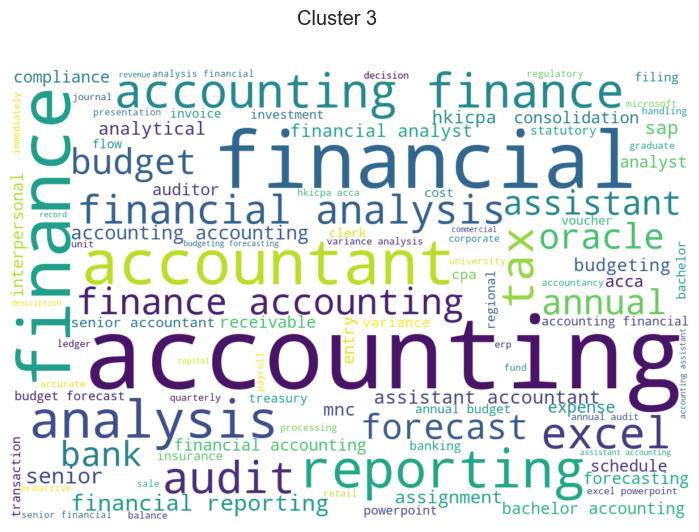

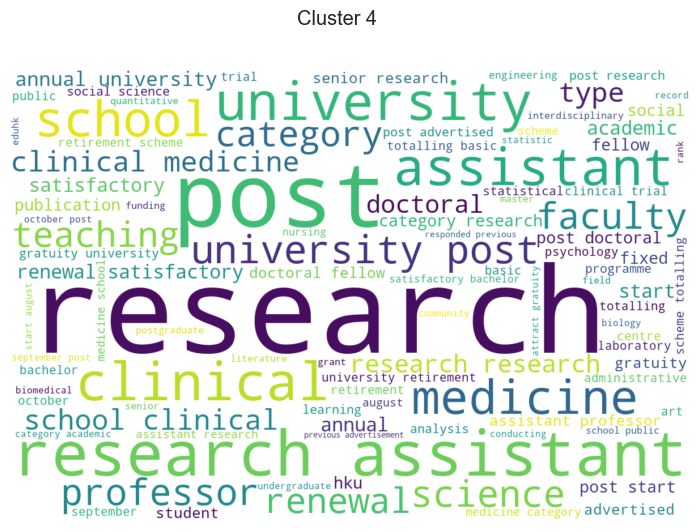

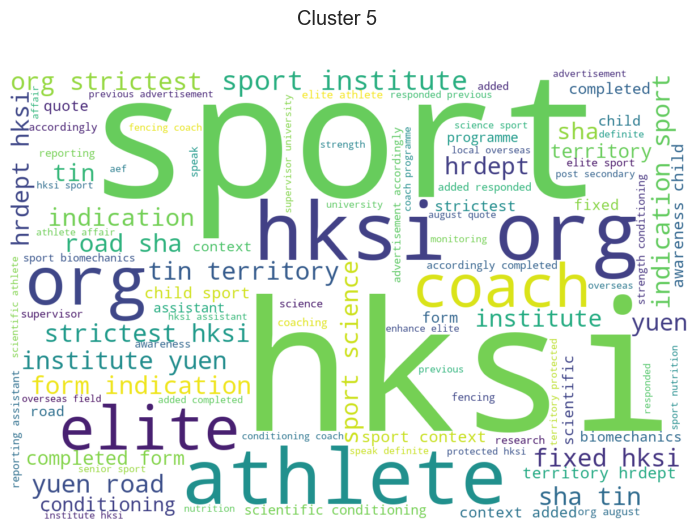

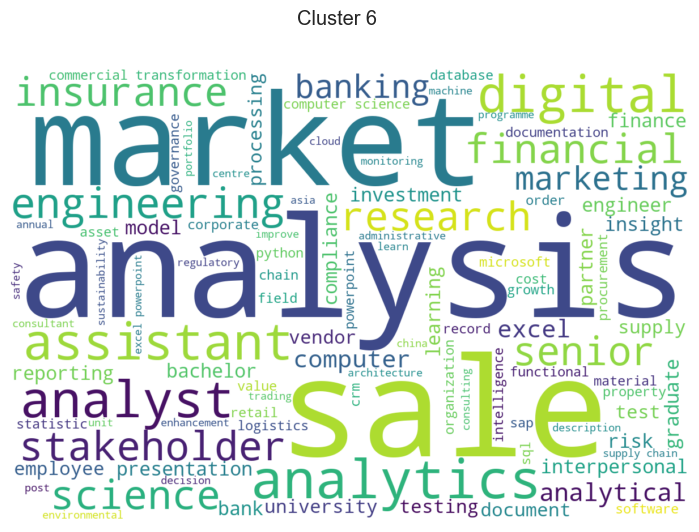

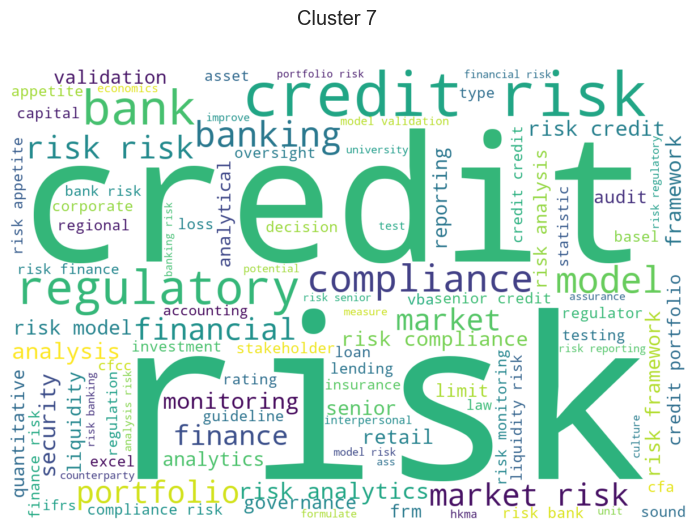

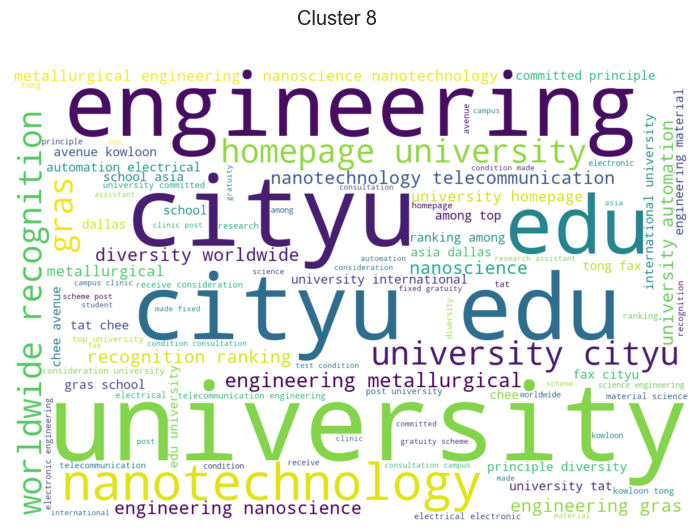

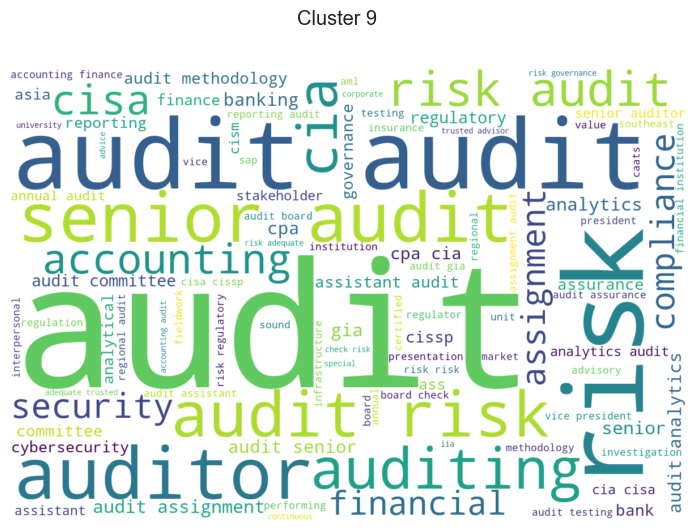

In [66]:
def generate_wordclouds(X, in_X_tfidf, k, in_word_positions, only_clustering=False):

    # Clustering
    in_model = KMeans(n_clusters=k, random_state=42)
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)
    silhouette_avg = silhouette_score(X, in_y_pred)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
    if only_clustering:
        return
    
    # Number of words with highest tfidf score to display
    top_count = 100

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        plt.show()

    return in_y_pred

import warnings
warnings.filterwarnings('ignore')

cluster_index = generate_wordclouds(X_svd, X_tfidf, 10, word_positions)

# Choose Cluster from Kmeans

#### Determine cluster that corresponds to data-related jobs

In [97]:
df['cluster'] = cluster_index
job_counts = df[df.job_title.str.contains('Data Engineer|Data Scientist|Data Analyst')].groupby(by='cluster').job_id.count()

#### Visualize the distribution of data jobs among clusters

array([[<AxesSubplot:title={'center':'cluster'}>]], dtype=object)

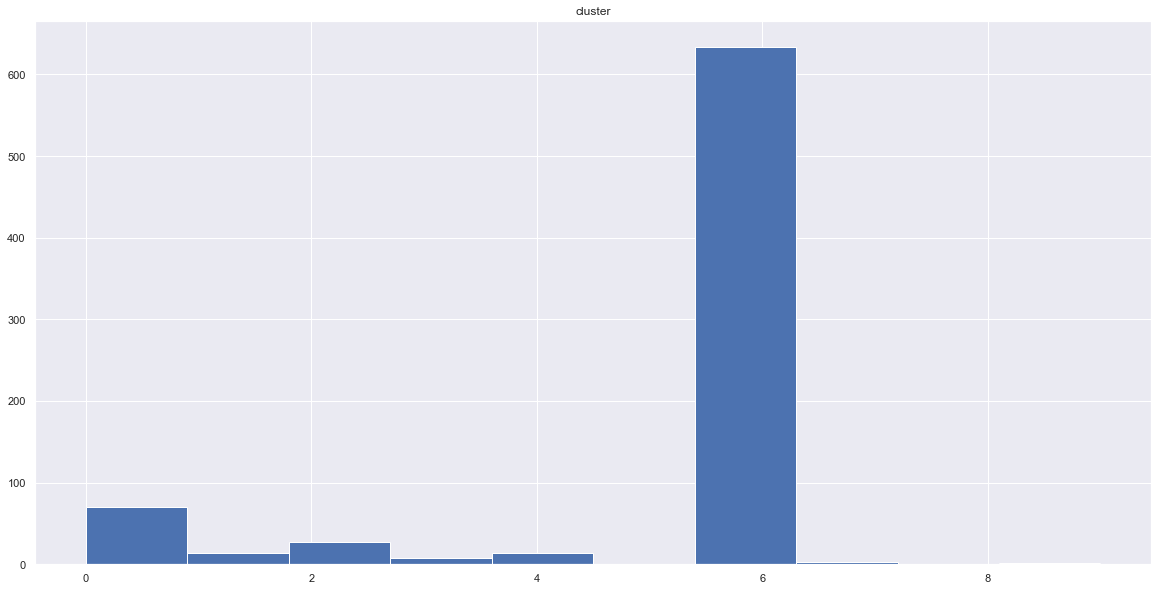

In [98]:
df[df.job_title.str.contains('Data Engineer|Data Scientist|Data Analyst')].hist(column='cluster')

In [99]:
chosen_cluster = job_counts.idxmax()

### Create master table for data related jobs

We take all the jobs from the chosen cluster - assuming that Kmeans have helped us group all the data-related jobs into the same cluster. We then also concatenate jobs from other clusters - jobs that specifically are titled with data-related keywords.

In [119]:
# data cluster + jobs from other clusters that have related titles, e.g. "data analyst"
chosen_cluster_df = df[df.cluster == chosen_cluster]

other_clusters_related_jobs = df[(df.cluster != chosen_cluster_df) & 
   (df.job_title.str.contains('Data|Machine Learning|Business Intelligence|Analytics|Computer Vision|NLP|Deep Learning|MLE|Data Management|ETL|SQL|Data warehouse', case=False))]

other_clusters_bi_jobs = df[(df.cluster != chosen_cluster_df) & 
   (df.job_title.str.contains('BI[\n)\s\]]|AI[\n)\s\]]', case=True))]

master_df = pd.concat([other_clusters_related_jobs, chosen_cluster_df, other_clusters_bi_jobs])

# drop ununsed columns
master_df = master_df.drop(columns=['job_id', 'official_post_date', 'min_official_salary', 'max_official_salary', 'job_type', 'job_functions', 'cluster'])

#### Fill in NaN values

In [127]:
chosen_cluster_df = df[df.cluster == chosen_cluster]
chosen_cluster_df.sample(30)

,job_id,job_title,company_name,job_description,location,official_post_date,min_official_salary,max_official_salary,career_level,qualification,job_type,job_functions,industry,min_salary,max_salary,mid_salary,agency,cluster
33628,100003009565412,"Senior Partner Relations Executive, Carrier Bu...",China Mobile International Limited,Responsibilities: Coordinate with overseas sal...,Kwai Hing,2022-08-01,NaN,NaN,Middle,Degree,"Full Time, Permanent",Marketing / Public Relations; Marketing - Gene...,Telecommunication,15000,40000,27500,False,6
44801,100003009640478,Business Analyst,Inter Partner Assistance Hong Kong Limited,What effort do you need to make? Responsible f...,Kwun Tong,2022-08-26,NaN,NaN,Middle,Degree,Full Time,Professional Services;Business Analysis / Data...,Others,15000,50000,32500,False,6
45752,100003009647669,Data Engineer,CTF Education Group Limited,Currently we are looking for a high caliber an...,Wan Chai,2022-08-30,NaN,NaN,Middle,Degree,Full Time,Banking / Finance;Analyst;Professional Service...,Education,30000,60000,45000,False,6
37030,100003009580882,Data Centre Technician / Operator,OneAsia Network Limited,Respo sibilities: Responsible for day-to-day o...,Kowloon Bay,2022-08-07,NaN,NaN,Entry Level,School Certificate,Full Time,Property / Real Estate;Others;Others;Technicia...,Information Technology,11000,30000,20500,False,6
7299,100003009756078,Data Steward Manager (70K) (Listed Company),Manpower Services (Hong Kong) Limited,"Our client a Listed Company in Hong Kong, look...",Aberdeen,2022-10-06,NaN,NaN,Senior,(N/A),Permanent,Information Technology (IT); IT Project Manage...,Human Resources Management/Consultancy,40000,80000,60000,True,6
31931,100003009572307,Accounts / Business Development Manager - Fina...,Robert Walters (HK),A leading research company is now expanding th...,NaN,2022-08-03,55000.0,90000.0,Middle,Degree,"Full Time, Permanent",Sales; CS & Business Devpt; Business Developme...,Human Resources Management/Consultancy,40000,120000,80000,False,6
43261,100003009620310,Sustainability SW Technical Specialist,IBM China / Hong Kong Ltd,Introduction : The sales teams at IBM are wor...,Quarry Bay,2022-08-20,NaN,NaN,NaN,NaN,Full Time,Information Technology (IT);Technical / Functi...,Information Technology,30000,60000,45000,False,6
1757,100003009612852,"Chief Strategy Officer, Index Business",Hang Seng Bank Ltd,Hang Seng Indexes Company Ltd Hang Seng Indexe...,NaN,2022-08-18,NaN,NaN,Senior,Degree,Full Time,Banking / Finance;Asset Management,Financial Services,20000,120000,70000,False,6
15301,100003009545603,"Associate, Liquidity Management, Treasury Mark...",Standard Chartered Bank (Hong Kong) Ltd,We are looking for a candidate with equally fo...,NaN,2022-07-26,NaN,NaN,Senior,Degree,Full Time,Banking / Finance; Retail Banking; Financial S...,Financial Services,50000,80000,65000,False,6
16675,100003009554135,Mixed Signal IC Design - Senior Lead Engineer,Hong Kong Applied Science and Technology Resea...,Reference #: CTO/ICS/ICET/2949/220706 Opening:...,Shatin Area,2022-07-28,NaN,NaN,NaN,Degree,"Full Time, Contract",Information Technology (IT); Application Speci...,Information Technology,30000,80000,55000,False,6


In [120]:
print(master_df.isna().sum())

master_df['location'] = master_df['location'].fillna('')
master_df['career_level'] = master_df['career_level'].fillna('')
master_df['qualification'] = master_df['qualification'].fillna('')
master_df['industry'] = master_df['industry'].fillna('')

job_title          43366
company_name       43366
job_description    43366
location           46056
career_level       47671
qualification      45755
industry           43757
min_salary         43366
max_salary         43366
mid_salary         43366
agency             43366
dtype: int64


#### Remove bad faith data

There are entries that have set the salary to have an unreasonable range - meaning it's put in bad faith.

In [115]:
master_df = master_df[(master_df.max_salary - master_df.min_salary <= 60000)]

#### Remove agency listings

In [116]:
# master_df = master_df[master_df.agency == False]

# EDA

#### Categorize job postings roughly by hand

In [117]:
def job_category(job_title):
    if re.search(r"Data[\s&\w]*Analyst", job_title, re.IGNORECASE):
        return 'DA'
    if re.search(r"Data Engineer|Data Migration Engineer", job_title, re.IGNORECASE):
        return 'DE'
    if re.search(r"Data Scientist|Data Science|AI", job_title, re.IGNORECASE):
        return 'DS'
    if re.search(r"Machine Learning Engineer|Machine Learning|MLops", job_title, re.IGNORECASE):
        return 'MLE'
    if re.search(r"Business Intelligence|BI Data Senior Engineer", job_title, re.IGNORECASE):
        return 'BI Dev'
    if re.search(r"BI|ETL|SQL", job_title):
        return 'BI Dev'
    if re.search(r"Computer Vision|NLP|Deep Learning", job_title, re.IGNORECASE):
        return 'ML Research'
    if re.search(r"Business Analyst|Business Analytics", job_title, re.IGNORECASE):
        return 'BA'
    if re.search(r"Data Governance|Data Quality|Data Management|Data Manager|Model|Modeling|Modelling", job_title, re.IGNORECASE):
        return 'Data Governance'
    if re.search(r"Data Architect", job_title, re.IGNORECASE):
        return 'Data Architect'
    if re.search(r"Data|Analytics|Analysis", job_title, re.IGNORECASE):
        if re.search(r"Software Engineer|Programmer|Developer|System Analyst|Systems Analyst|Data Integration", job_title, re.IGNORECASE):
            return "DE"
        if re.search(r"Architect", job_title, re.IGNORECASE):
            return "Data Architect"
        if re.search(r"Market|Marketing|CRM|Digital", job_title, re.IGNORECASE):
            return "Marketing DA"
        if re.search(r"Research", job_title, re.IGNORECASE):
            return "ML Research"
        if re.search(r"Officer, Data Analytics|Officer, Data Analysis", job_title, re.IGNORECASE):
            return "DA"
        if re.search(r"Lead|Manager|Director|Leader|Head|VP|Vice President|Evangelist|Principal", job_title, re.IGNORECASE):
            return "Management"
        if re.search(r"Senior Analyst", job_title, re.IGNORECASE):
            return "DA"
        else:
            return 'Others'
    else:
        return 'Others'

master_df['category'] = [job_category(title) for title in master_df['job_title']]
print(master_df["category"].value_counts())

Others             8509
DS                  970
BA                  711
DA                  387
Management          232
DE                  173
BI Dev              161
Data Governance     105
Marketing DA         57
MLE                  32
Data Architect       22
ML Research          17
Name: category, dtype: int64


In [112]:
master_df[master_df.category != 'Others'].sample(20)

,job_title,company_name,job_description,location,career_level,qualification,industry,min_salary,max_salary,mid_salary,agency,category
44169,Computer Vision Engineer,Neo Derm (HK) Ltd,About us: With the trend towards Industrial Re...,Quarry Bay,Entry Level,Degree,Health & Beauty Care,11000.0,20000.0,15500.0,False,ML Research
9740,"Data Scientist - New headcount, multinational ...",Terminal 1 Limited,Our client is a well-established corporation i...,Others,,,Human Resources Management/Consultancy,40000.0,80000.0,60000.0,True,DS
45433,"Vice President / Assistant Vice President, Big...",China Construction Bank (Asia) Corporation Lim...,"Responsibilities: Explore the availability, ac...",,,Degree,Financial Services,30000.0,60000.0,45000.0,False,MLE
10400,Data Engineer - Insurance - 45k - Contract,Protiviti Hong Kong,Protiviti are looking for skilled candidates f...,Kwun Tong Area,Middle,Degree,Human Resources Management/Consultancy,20000.0,50000.0,35000.0,True,DE
19555,Project Coordinator [ $25127/ 9M/ Wan Chai/ Go...,Nova Management Consultants Ltd,Duties : To coordinate with Information Techno...,Wan Chai,,,Human Resources Management/Consultancy,15000.0,30000.0,22500.0,False,DS
37570,Chemist Trainee (H&N-Food),SGS Hong Kong Limited,"Key responsibilities: Prepare standard, workin...",Fanling,Entry Level,Degree,Laboratory,11000.0,15000.0,13000.0,False,DS
34604,Assistant Business Analyst / Business Analyst,The Hong Kong And China Gas Co Ltd,The Role: Conduct business and process analysi...,Quarry Bay,Entry Level,Degree,Public Utilities,11000.0,15000.0,13000.0,False,BA
29540,(Senior) Retail Analyst,DFI Retail Group DFI零售集團,Is this your next challenge in retail analytic...,Quarry Bay,Middle,Degree,Wholesale / Retail,11000.0,40000.0,25500.0,False,DS
13584,Data Governance Consultant,Computer Recruitment Consultants Ltd,"One of our clients, an insurance company is cu...",,Senior,Degree,Human Resources Management/Consultancy,40000.0,80000.0,60000.0,False,Data Governance
31581,CRM Data Entry Officer,WSP (Asia) Limited,WSP is looking for the CRM Data Entry Officer ...,Kowloon Bay,,,"Engineering - Building, Civil, Construction / ...",15000.0,30000.0,22500.0,False,Marketing DA


In [18]:
pivot = master_df[(master_df.category != 'Others') & (master_df.career_level != '')].drop(columns=['job_id', 'agency', 'mid_salary']).groupby(by=["career_level", "category"]).mean().astype(int)

pivot.style.background_gradient(axis=0)

# # Draw a heatmap with the numeric values in each cell
# f, ax = plt.subplots(figsize=(10, 15))
# sns.heatmap(pivot, annot=True, fmt="d", linewidths=.5, ax=ax)

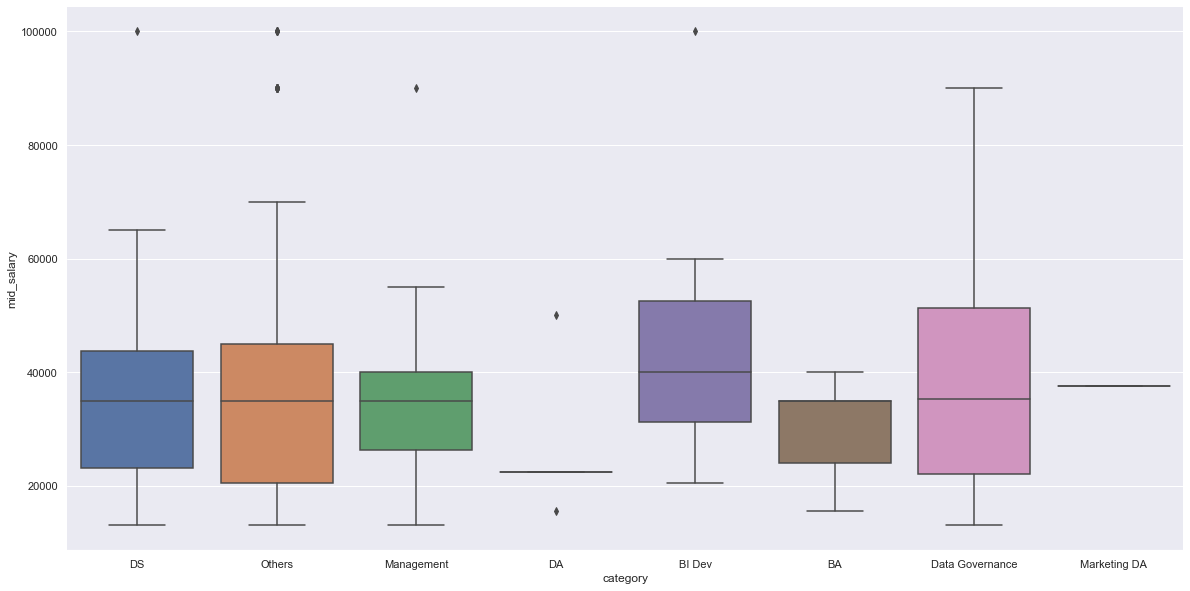

In [19]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,10)})
sns.boxplot(data=master_df, x="category", y="mid_salary")
sns.despine(left=True)

## Explore relationship between skills and salary

In [20]:
skills = ['google cloud', 'aws', 'azure',
         'bigquery', 'redshift', 'databricks', 'snowflake',
         'airflow', 'dbt', 'prefect', 'dagster', 'airbyte',
         'spark', 'flink', 'kafka', 'hadoop',
         'etl', 'elt',
         'data governance',
         'oracle', 'sas', 'sap',
         'python', 'sql', 'pl/sql', 't-sql', ' r ',
         'tensorflow', 'deep learning', 'sklearn', 'scikit']

dictionary = {}

skills_df = pd.DataFrame(skills, columns=['skill'])
skills_df['job_count'] = skills_df['skill'].map(lambda x: master_df[master_df.job_description.str.contains(x, case=False)].job_id.count())
skills_df['mid_salary'] = skills_df['skill'].map(lambda x: master_df[master_df.job_description.str.contains(x, case=False)].mid_salary.mean())
skills_df.style.background_gradient(axis=0)  

,skill,job_count,mid_salary
0,google cloud,1,40000.000000
1,aws,53,38018.867925
2,azure,2,45000.000000
3,bigquery,1,22500.000000
4,redshift,0,nan
5,databricks,1,50000.000000
6,snowflake,0,nan
7,airflow,0,nan
8,dbt,0,nan
9,prefect,0,nan


# Train Prediction Model

In [21]:
# Here are the categorical features we are going to create one-hot encoded features for
categorical_features = ['location','career_level','qualification', 'industry'] 

encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
one_hot_features = encoder.fit_transform(master_df[categorical_features])
one_hot_names = encoder.get_feature_names()
print("Shape of one_hot_features: ", one_hot_features.shape)

print("Type of one_hot_columns is:",type(one_hot_features))

Shape of one_hot_features:  (469, 57)
Type of one_hot_columns is: <class 'scipy.sparse._csr.csr_matrix'>


#### Add categorical variables as one_hot encoding

In [22]:
from sklearn.model_selection import train_test_split

# Combine numerical features with one-hot-encoded features
features = one_hot_features
all_feature_names =one_hot_names

target_column = ['mid_salary'] # We will fit log(1 + price) 
target = master_df[target_column].values

# Perform train and test split of data
rand_seed = 51 # For other models we will use the same random seed, so that we're always using the same train-test split
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=rand_seed)

In [23]:
%%time
from sklearn import linear_model

ridge_fit = linear_model.RidgeCV(cv=5)
ridge_fit.fit(features_train, target_train)
print("RidgeCV found an optimal regularization parameter alpha =",ridge_fit.alpha_)
test_score_no_text = ridge_fit.score(features_test,target_test)
print("Test score for Ridge Regression without text features:", test_score_no_text)

RidgeCV found an optimal regularization parameter alpha = 10.0
Test score for Ridge Regression without text features: 0.2383312374809492
CPU times: total: 62.5 ms
Wall time: 112 ms


#### Add text as features

In [24]:
stopwords = custom_import_stopwords('english_stopwords.csv')

# Custom tokenizer for tfidf representation
vectorizer = TfidfVectorizer(input='content', tokenizer=LemmaTokenizer(), ngram_range=(1, 1))

# Same train-test split as before (same random seed)
data_train, data_test = train_test_split(master_df, test_size=0.2, random_state=rand_seed)

# Here we need the correct path in order to give it to the vectorizer
print("Generating TFIDF sparse matrix...")
X = (data_train['company_name'] + ' ' + data_train['job_title']).values
X_tfidf = vectorizer.fit_transform(X)
num_words = len(vectorizer.vocabulary_)
print("Number of distinct words to be used as features:",num_words)

789 stopwords imported
Generating TFIDF sparse matrix...
Number of distinct words to be used as features: 356


In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# Same train-test split as before (same random seed)
data_train, data_test = train_test_split(master_df, test_size=0.2, random_state=rand_seed)

training_corpus = (data_train['company_name'] + ' ' + data_train['job_title']).values # Only use the training set to define the features we are going to extract
vectorizer = CountVectorizer(min_df=3) 
# min_df is the minimum number of times a word needs to appear in the corpus in order to be assigned a vector
vectorizer.fit(training_corpus)
num_words = len(vectorizer.vocabulary_) # Total number of words 
print("Number of distinct words to be used as features:",num_words)

Number of distinct words to be used as features: 179


In [26]:
full_corpus =(master_df['company_name'] + ' ' + master_df['job_title']).values
word_features = vectorizer.transform(full_corpus) # This is a sparse matrix of our word-occurrence features 
words = vectorizer.get_feature_names() # The actual words corresponding to the columns of the above feature matrix
word_frequencies = np.array(word_features.sum(axis=0))[0] # The total number of occurrences of each word in the dataset
print("Shape of word-occurrence feature matrix:",word_features.shape)

Shape of word-occurrence feature matrix: (469, 179)


In [27]:
num_non_text = features.shape[1]
features_with_text = scipy.sparse.hstack((features, word_features),format='csr') 
# We want to keep the feature matrix in a sparse format for efficiency
feature_names = np.hstack((all_feature_names, words))   

# Same train-test split as before (same random seed)
features_with_text_train, features_with_text_test, target_train, target_test = train_test_split(
    features_with_text, target, test_size=0.2, random_state=rand_seed)

num_features = num_non_text + num_words

print("Number of non-text features: ",num_non_text)
print("Number of vectorized text features (word occurrences): ",num_words)
print("Features shape including text features: ",features_with_text.shape)

Number of non-text features:  57
Number of vectorized text features (word occurrences):  179
Features shape including text features:  (469, 236)


### Run Ridge Regression

In [28]:
%time
from sklearn import linear_model

ridge_fit = linear_model.RidgeCV(cv=5, alphas=[a for a in range(1, 100, 5)], scoring="neg_mean_absolute_error")
ridge_fit.fit(features_with_text_train, target_train)
print("RidgeCV found an optimal regularization parameter alpha =",ridge_fit.alpha_)
test_score_with_text = ridge_fit.score(features_with_text_test,target_test)
print("Test score for Ridge Regression WITH text features:", test_score_with_text)

CPU times: total: 0 ns
Wall time: 0 ns
RidgeCV found an optimal regularization parameter alpha = 11
Test score for Ridge Regression WITH text features: 0.22923385589177292


In [29]:
features_with_text_train.shape

(375, 236)

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD

# define the model
# model = RandomForestRegressor()
# pca = TruncatedSVD(n_components=512)
# pca.fit(features_with_text_train)
# print("PCA Explained Ratio:", np.sum(pca.explained_variance_ratio_))

# pca_features_with_text_train = pca.transform(features_with_text_train)
# pca_features_with_text_test = pca.transform(features_with_text_test)

# # evaluate the model
# cv = KFold(n_splits=5, random_state=1, shuffle=True)
# n_scores = cross_val_score(
#     model, 
#     pca_features_with_text_train, 
#     target_train, 
#     scoring='neg_mean_squared_error', 
#     cv=cv, n_jobs=-1, error_score='raise'
# )
# print(f"Cross Validation Mean Squared Error:, {-n_scores.mean()}")

In [31]:
# Retrain with the CV-tuned params
# model = RandomForestRegressor()
# model.fit(
#     pca_features_with_text_train, 
#     target_train,
# )
# test_y = model.predict(pca_features_with_text_test)

# error = mean_squared_error(target_test, test_y)

# print(f"Test Set Mean Squared Error:, {error}")

# report_df = pd.DataFrame({
#     "prediction": test_y,
#     "truth": target_test.reshape(-1),
#     "% Error": 100*np.abs(test_y-target_test.reshape(-1))/target_test.reshape(-1)
# })

# print(f"Test Set Mean Absolute % Error:, {report_df['% Error'].mean()}")

In [32]:
report_df

NameError: name 'report_df' is not defined

## Analysis of Model

#### Importance of features

In [ ]:
coefs = ridge_fit.coef_[0] # Coefficients of the linear fit

# I'll make a num_features-sized array of zeros, and then fill the indices corresponding to the word-occurrence features
# with the total number of counts for the word in that dataset. So features that don't correspond to words have 
# word_counts = 0.
num_features = features_with_text.shape[1]
word_counts = np.zeros(num_features, dtype=int)
word_counts[num_non_text:] = word_frequencies

# Make a DataFrame of feature names, coefficients, and word counts, and sort it by magnitude of the coefficient.
coef_df = pd.DataFrame(data={'names': feature_names, 'coefs': coefs, 'total_word_counts': word_counts})
coef_df_sorted = coef_df.reindex(coef_df['coefs'].abs().sort_values(ascending=False).index)

In [ ]:
with pd.option_context('display.max_rows', None): 
    print(coef_df_sorted.head(200))